# Energy Consumption Forecasting Project
## Initial Data Exploration & Pipeline Demonstration

### 1. Project Setup

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Markdown, display
import seaborn as sns
import sys
sys.path.append('../')
from src.data_preparation import download_and_extract_data, aggregate_data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn-v0_8-whitegrid') 
pd.set_option('display.max_columns', 50)

In [68]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summ['Missing#'] = df.isna().sum()
    summ['Missing%'] = df.isna().mean()
    summ['Dups'] = df.duplicated().sum()
    summ['Uniques'] = df.nunique().values
    summ['Count'] = df.count().values
    desc = df.describe(include='all').transpose()
    first_vals = df.head(3).T if len(df) > 0 else pd.DataFrame()
    summ['Min'] = desc['min'].values
    summ['Max'] = desc['max'].values
    summ['Average'] = desc['mean'].values
    summ['Standard Deviation'] = desc['std'].values
    
    summ['First Value'] = first_vals.iloc[:,0].values if len(first_vals) > 0 else None
    summ['Second Value'] = first_vals.iloc[:,1].values if len(first_vals) > 1 else None
    summ['Third Value'] = first_vals.iloc[:,2].values if len(first_vals) > 2 else None
    display(summ)

### 2. Raw Data Inspection and handlling nulls

In [69]:
raw_path = r'C:\Users\AliRashaideh\OneDrive - Seagulls\Desktop\energy_forecasting_project\data\raw\household_power_consumption.csv'
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
RAW_DIR = './data/raw'
raw_file_path = download_and_extract_data(DATA_URL, RAW_DIR)

Downloading: 19.7MB [00:17, 1.15MB/s]


Extracting dataset...


In [70]:
print("Loading data...")
df_without_na = pd.read_csv(raw_file_path, sep=';')
print("Loading data...")
df = pd.read_csv(raw_file_path, sep=';', na_values=['?', 'nan'], parse_dates={'datetime': ['Date', 'Time']})
df.set_index('datetime', inplace=True)

Loading data...


C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_17900\2964537705.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_without_na = pd.read_csv(raw_file_path, sep=';')
C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_17900\2964537705.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(raw_file_path, sep=';', na_values=['?', 'nan'], parse_dates={'datetime': ['Date', 'Time']})


Loading data...


C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_17900\2964537705.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(raw_file_path, sep=';', na_values=['?', 'nan'], parse_dates={'datetime': ['Date', 'Time']})


In [71]:
Markdown("### Data without na_values parameter Summary")
summary(df_without_na)
Markdown("### Data with na_values parameter Summary")
summary(df)

data shape: (2075259, 9)


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,First Value,Second Value,Third Value
Date,object,0,0.000000,0,1442,2075259,NaN,NaN,NaN,NaN,16/12/2006,16/12/2006,16/12/2006
Time,object,0,0.000000,0,1440,2075259,NaN,NaN,NaN,NaN,17:24:00,17:25:00,17:26:00
Global_active_power,object,0,0.000000,0,6534,2075259,NaN,NaN,NaN,NaN,4.216,5.360,5.374
Global_reactive_power,object,0,0.000000,0,896,2075259,NaN,NaN,NaN,NaN,0.418,0.436,0.498
Voltage,object,0,0.000000,0,5168,2075259,NaN,NaN,NaN,NaN,234.840,233.630,233.290
Global_intensity,object,0,0.000000,0,377,2075259,NaN,NaN,NaN,NaN,18.400,23.000,23.000
Sub_metering_1,object,0,0.000000,0,153,2075259,NaN,NaN,NaN,NaN,0.000,0.000,0.000
Sub_metering_2,object,0,0.000000,0,145,2075259,NaN,NaN,NaN,NaN,1.000,1.000,2.000
Sub_metering_3,float64,25979,0.012518,0,32,2049280,0.0,31.0,6.458447,8.437154,17.0,16.0,17.0


data shape: (2075259, 7)


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,First Value,Second Value,Third Value
Global_active_power,float64,25979,0.012518,168560,4186,2049280,0.076,11.122,1.091615,1.057294,4.216,5.360,5.374
Global_reactive_power,float64,25979,0.012518,168560,532,2049280,0.000,1.390,0.123714,0.112722,0.418,0.436,0.498
Voltage,float64,25979,0.012518,168560,2837,2049280,223.200,254.150,240.839858,3.239987,234.840,233.630,233.290
Global_intensity,float64,25979,0.012518,168560,221,2049280,0.200,48.400,4.627759,4.444396,18.400,23.000,23.000
Sub_metering_1,float64,25979,0.012518,168560,88,2049280,0.000,88.000,1.121923,6.153031,0.000,0.000,0.000
Sub_metering_2,float64,25979,0.012518,168560,81,2049280,0.000,80.000,1.298520,5.822026,1.000,1.000,2.000
Sub_metering_3,float64,25979,0.012518,168560,32,2049280,0.000,31.000,6.458447,8.437154,17.000,16.000,17.000


In [72]:
df.fillna(method='ffill', inplace=True)

print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_17900\3016363283.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## EDA

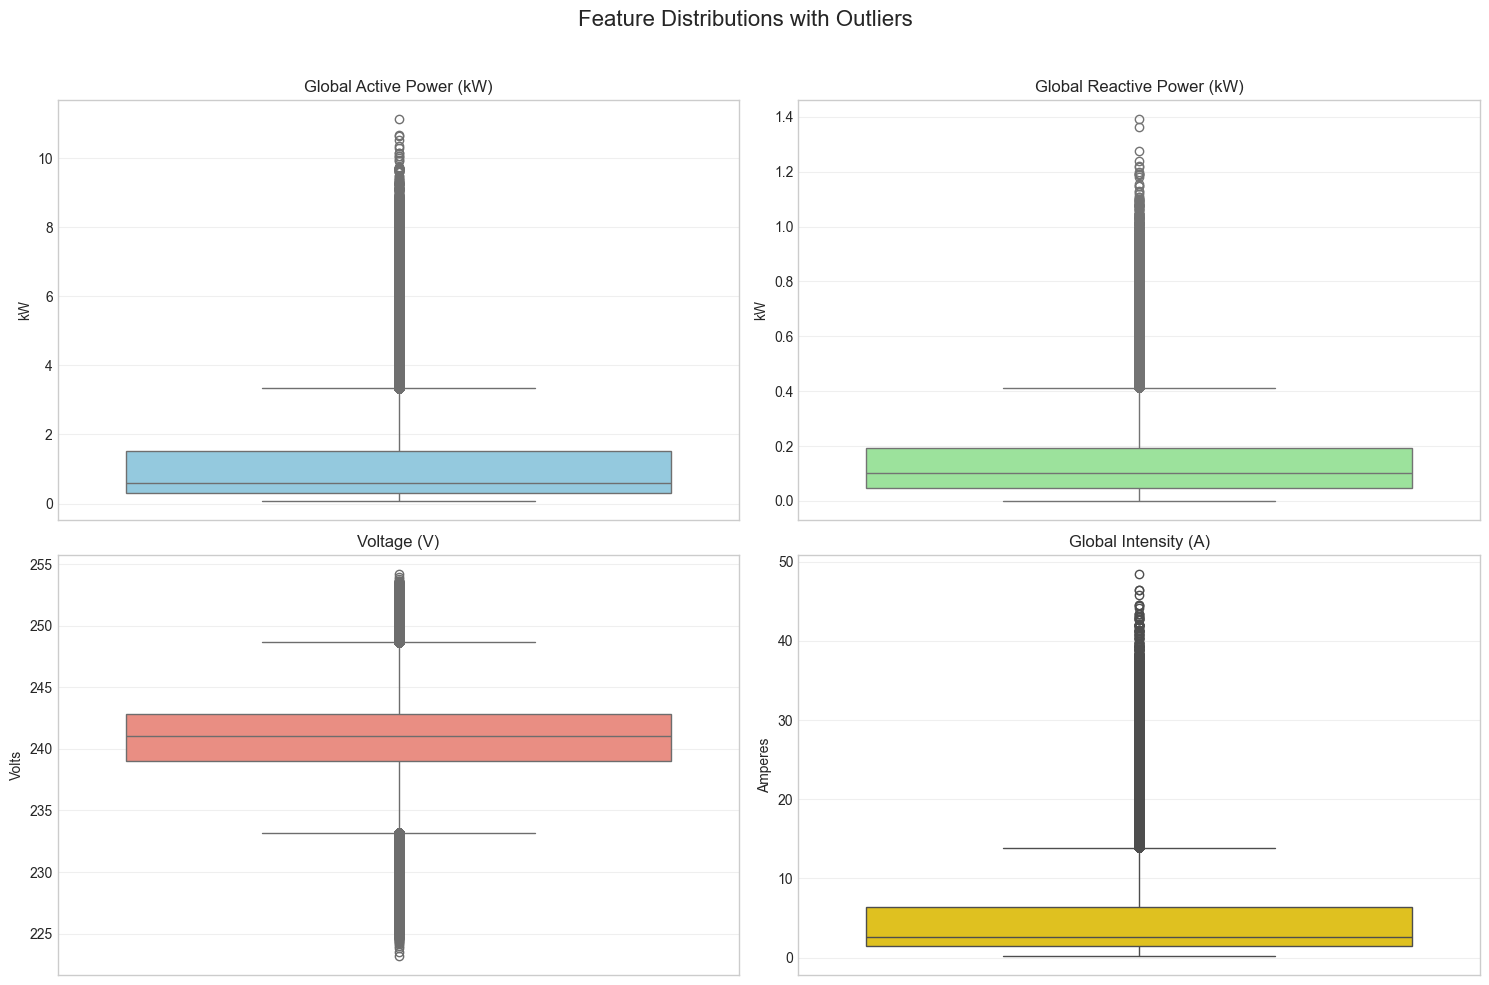

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Feature Distributions with Outliers', fontsize=16)

# Global_active_power
sns.boxplot(y=df['Global_active_power'], ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Global Active Power (kW)')
axes[0,0].set_ylabel('kW')
axes[0,0].grid(axis='y', alpha=0.3)

# Global_reactive_power
sns.boxplot(y=df['Global_reactive_power'], ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Global Reactive Power (kW)')
axes[0,1].set_ylabel('kW')
axes[0,1].grid(axis='y', alpha=0.3)

# Voltage
sns.boxplot(y=df['Voltage'], ax=axes[1,0], color='salmon')
axes[1,0].set_title('Voltage (V)')
axes[1,0].set_ylabel('Volts')
axes[1,0].grid(axis='y', alpha=0.3)

# Global_intensity
sns.boxplot(y=df['Global_intensity'], ax=axes[1,1], color='gold')
axes[1,1].set_title('Global Intensity (A)')
axes[1,1].set_ylabel('Amperes')
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Actual Bounds: Lower=0.00 kW, Upper=3.35 kW


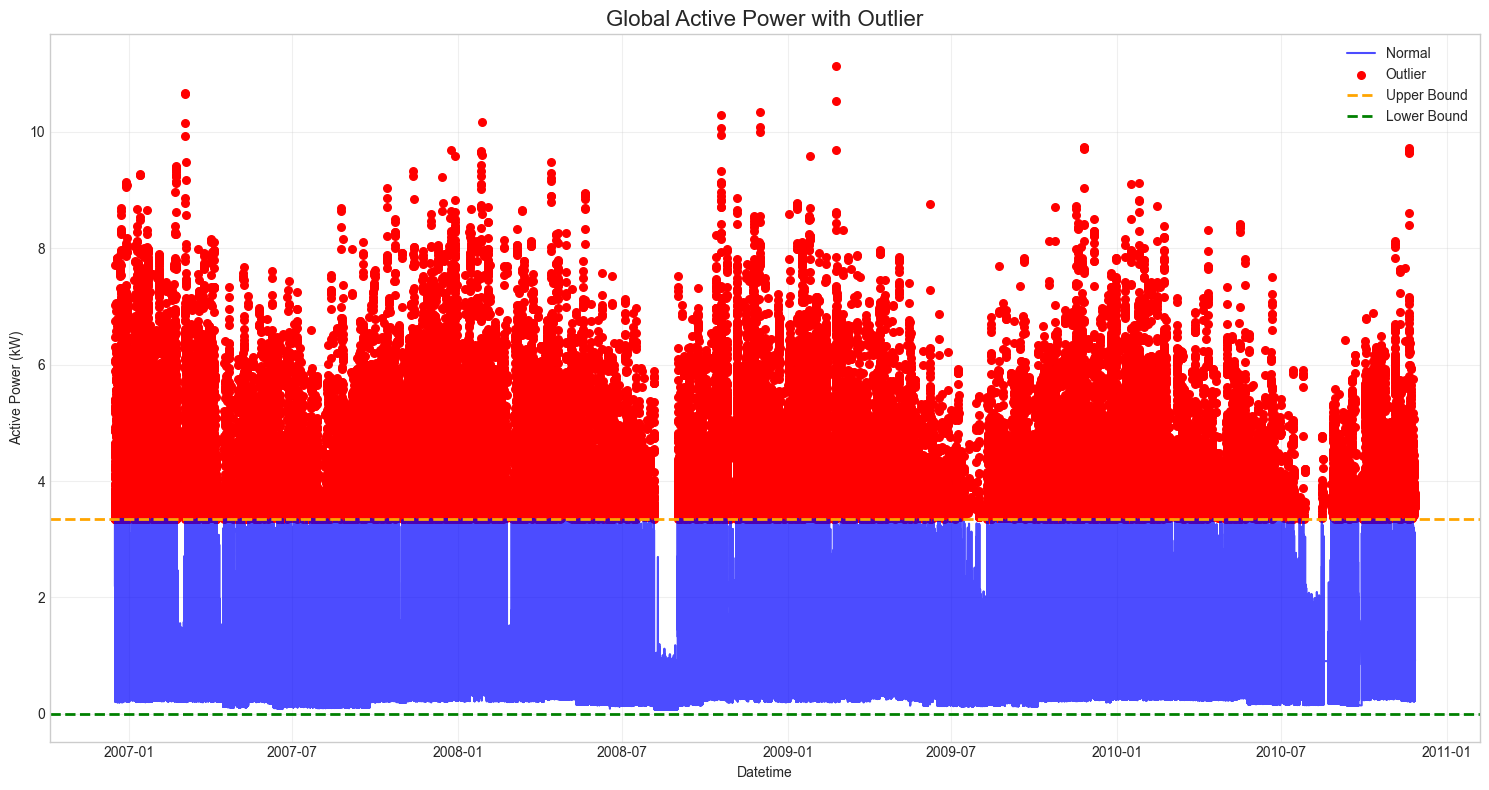

In [74]:
Q1 = df['Global_active_power'].quantile(0.25)
Q3 = df['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = max(Q1 - 1.5 * IQR, 0)  # Power can't be negative

print(f"Actual Bounds: Lower={lower_bound:.2f} kW, Upper={upper_bound:.2f} kW")

# Create CORRECT plot
plt.figure(figsize=(15, 8))

# Plot normal data
normal_data = df[(df['Global_active_power'] >= lower_bound) & 
                 (df['Global_active_power'] <= upper_bound)]
plt.plot(normal_data.index, normal_data['Global_active_power'], 
         'b-', alpha=0.7, label='Normal')

# Plot outliers
outliers = df[(df['Global_active_power'] > upper_bound) | 
              (df['Global_active_power'] < lower_bound)]
plt.scatter(outliers.index, outliers['Global_active_power'], 
            color='red', s=30, label='Outlier')

plt.axhline(upper_bound, color='orange', linestyle='--', linewidth=2, label='Upper Bound')
plt.axhline(lower_bound, color='green', linestyle='--', linewidth=2, label='Lower Bound')

plt.title('Global Active Power with Outlier', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Active Power (kW)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

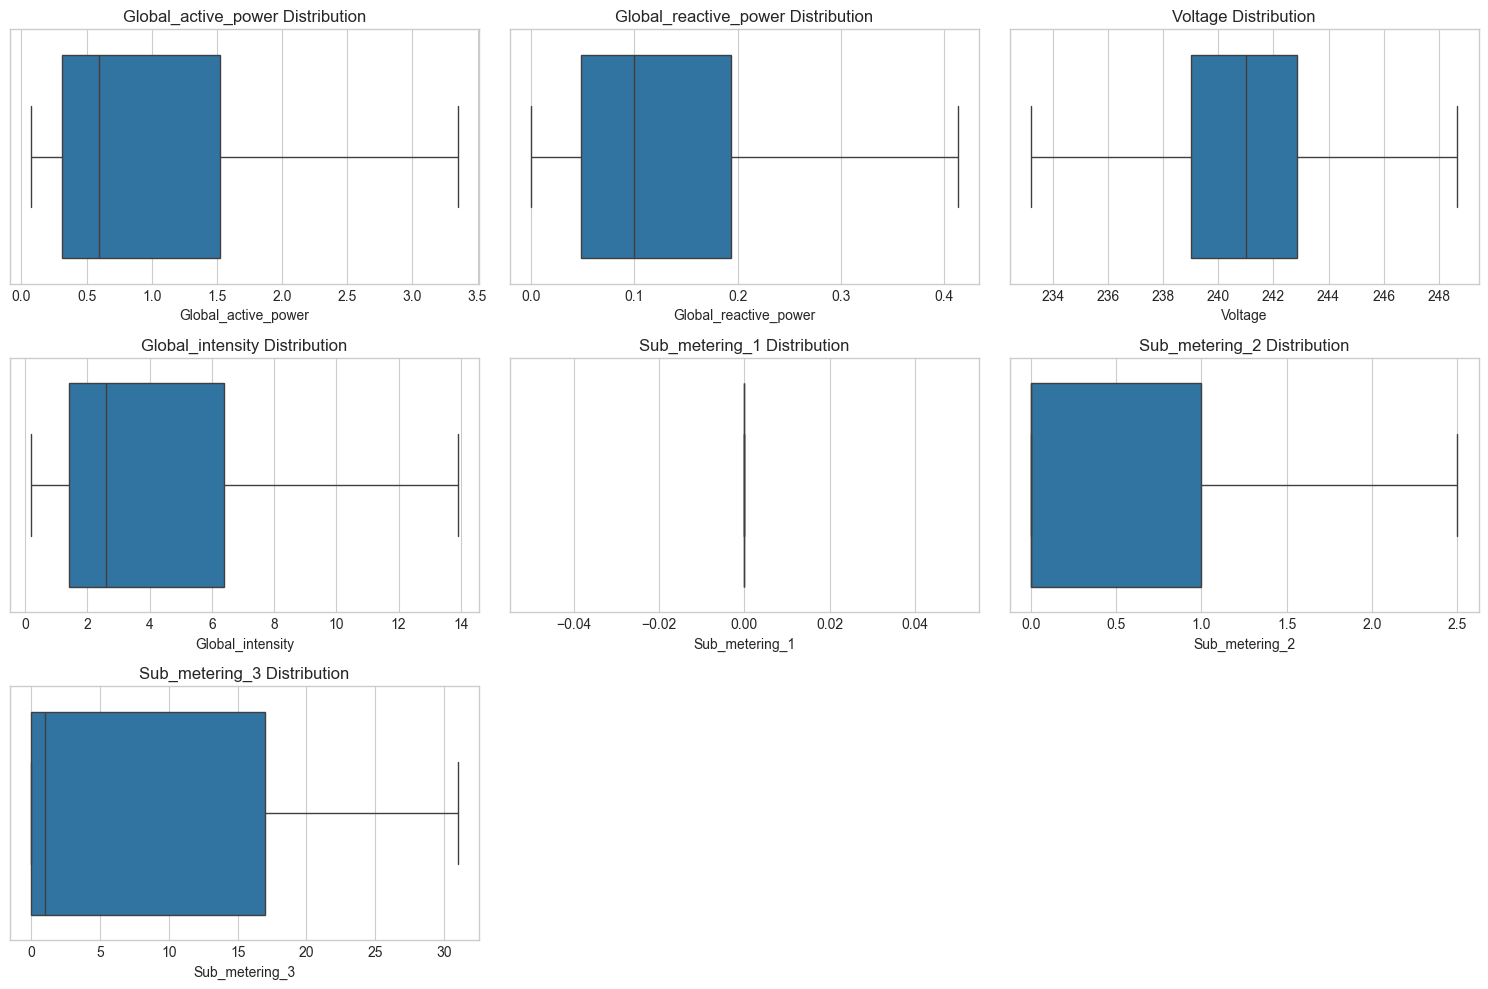

In [75]:
def handle_outliers(series):
    # Only process numeric columns
    if pd.api.types.is_numeric_dtype(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        lower_bound = max(Q1 - 1.5 * IQR, 0)  # Power can't be negative
        return series.clip(lower_bound, upper_bound)
    return series  # Return non-numeric columns unchanged

# Apply only to numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].apply(handle_outliers)

# Visualize outliers treatment for numeric columns only
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()


In [85]:
def aggregate_data(df):
    """Create aggregated datasets at different time frequencies"""
    print("Aggregating data...")
    aggregations = {
        'Global_active_power': 'sum',
        'Global_reactive_power': 'sum',
        'Voltage': 'mean',
        'Global_intensity': 'mean',
        'Sub_metering_1': 'sum',
        'Sub_metering_2': 'sum',
        'Sub_metering_3': 'sum',
    }
    
    hourly = df.resample('H').agg(aggregations)
    daily = df.resample('D').agg(aggregations)
    weekly = df.resample('W').agg(aggregations)
    
    return {
        'hourly': hourly,
        'daily': daily,
        'weekly': weekly
    }
new_df=aggregate_data(df)

Aggregating data...


C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_17900\1838407871.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df.resample('H').agg(aggregations)


#### Visualizing the data

In [87]:
hourly = new_df['hourly']
daily = new_df['daily']
weekly = new_df['weekly']

##### Temporal Pattern Analysis

C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_17900\826958805.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = daily.resample('M').sum()


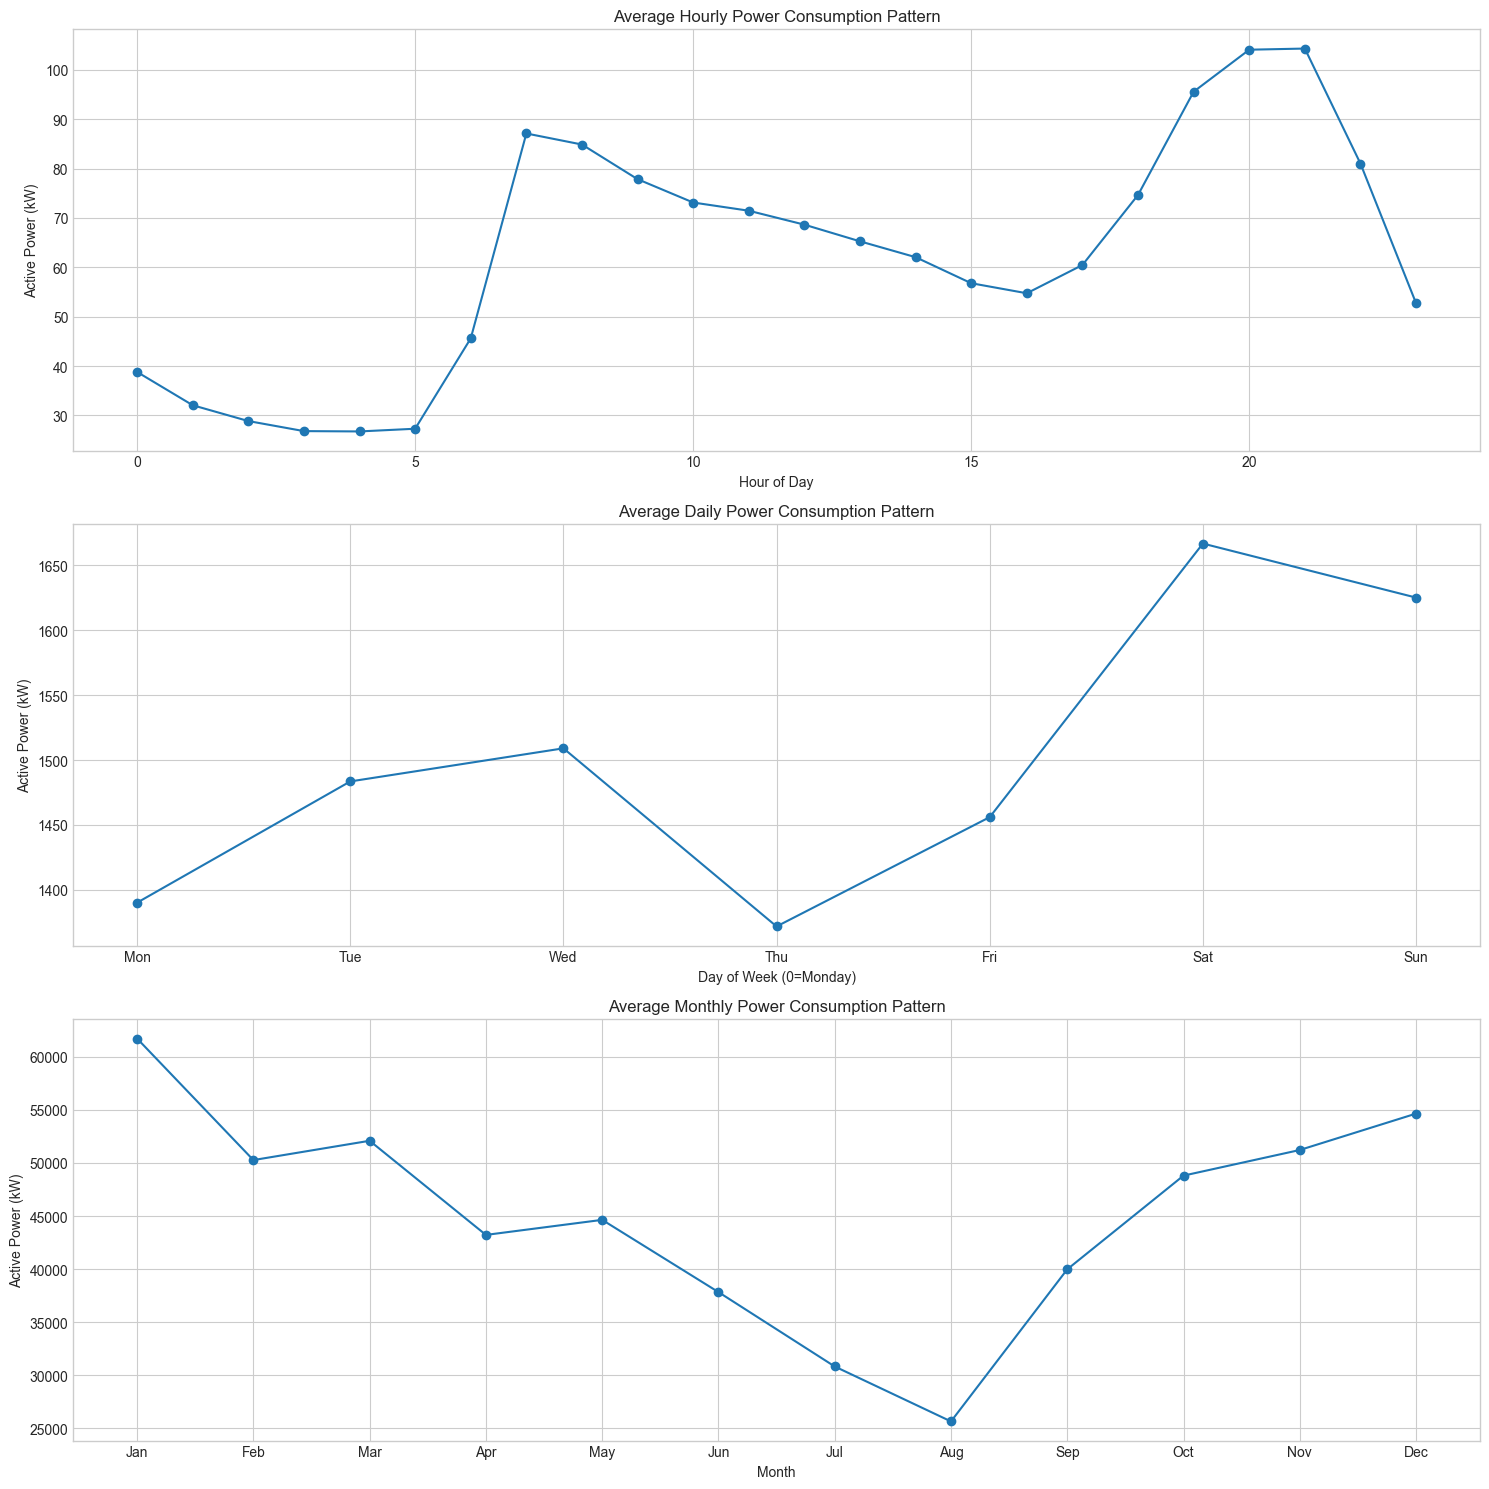

In [89]:
def plot_temporal_patterns(data_dict):
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    
    # Hourly patterns
    hourly = data_dict['hourly']
    hourly['hour'] = hourly.index.hour
    hourly.groupby('hour')['Global_active_power'].mean().plot(ax=axes[0], marker='o')
    axes[0].set_title('Average Hourly Power Consumption Pattern')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Active Power (kW)')
    axes[0].grid(True)
    
    # Daily patterns
    daily = data_dict['daily']
    daily['dayofweek'] = daily.index.dayofweek
    daily.groupby('dayofweek')['Global_active_power'].mean().plot(ax=axes[1], marker='o')
    axes[1].set_title('Average Daily Power Consumption Pattern')
    axes[1].set_xlabel('Day of Week (0=Monday)')
    axes[1].set_ylabel('Active Power (kW)')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes[1].grid(True)
    
    # Monthly patterns
    monthly = daily.resample('M').sum()
    monthly['month'] = monthly.index.month
    monthly.groupby('month')['Global_active_power'].mean().plot(ax=axes[2], marker='o')
    axes[2].set_title('Average Monthly Power Consumption Pattern')
    axes[2].set_xlabel('Month')
    axes[2].set_ylabel('Active Power (kW)')
    axes[2].set_xticks(range(1, 13))
    axes[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_temporal_patterns(new_df)

##### Time Series Decomposition

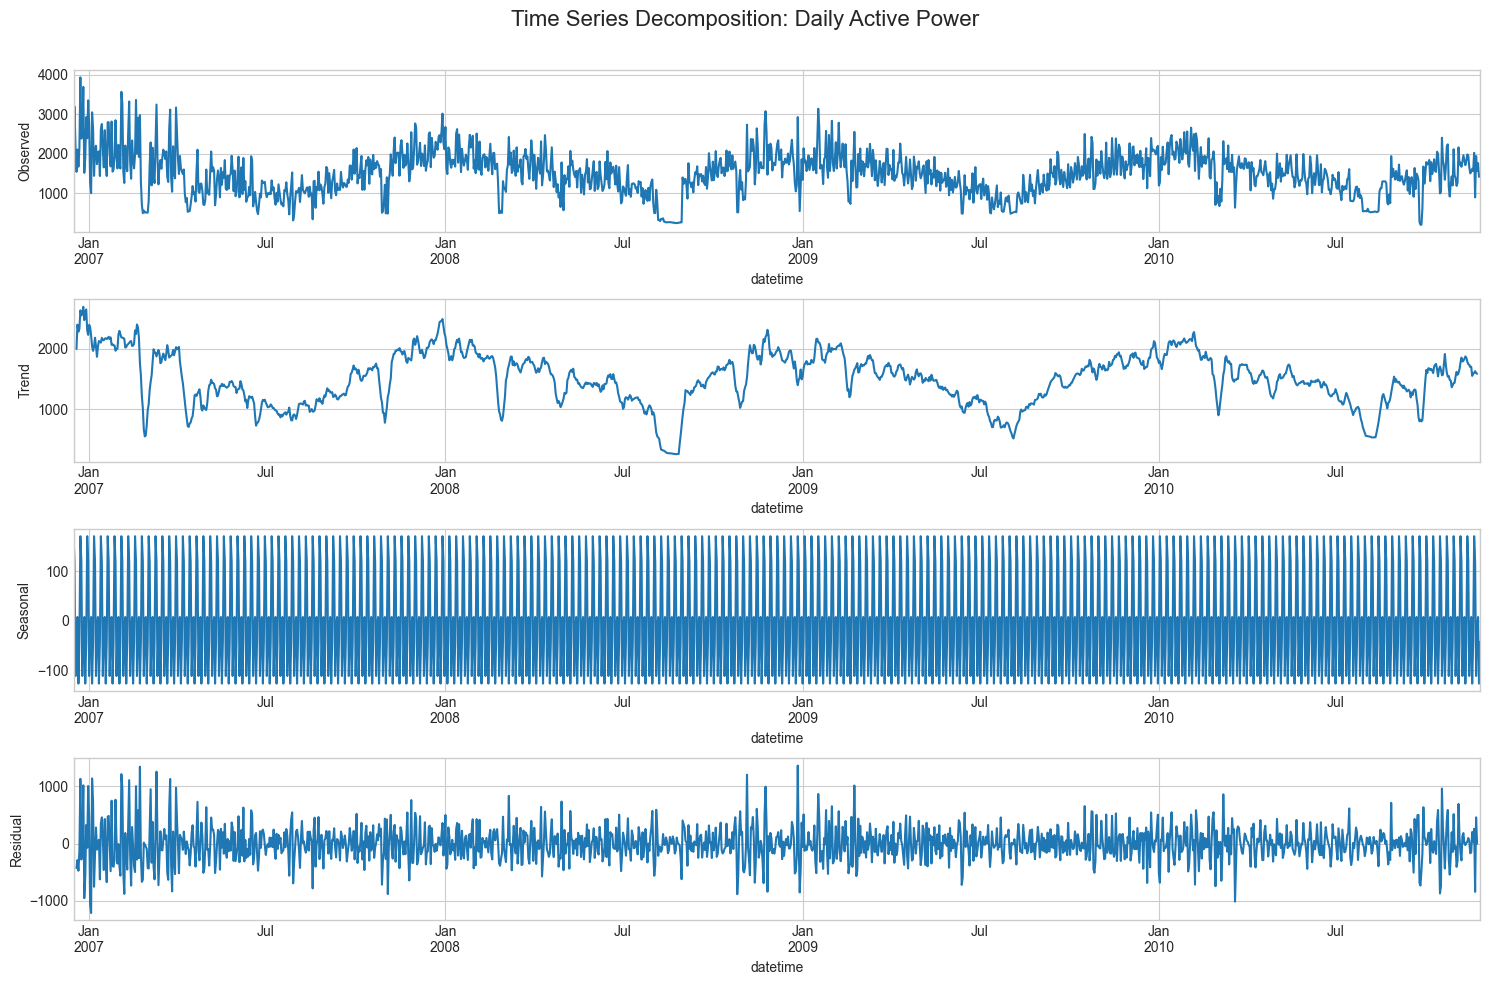

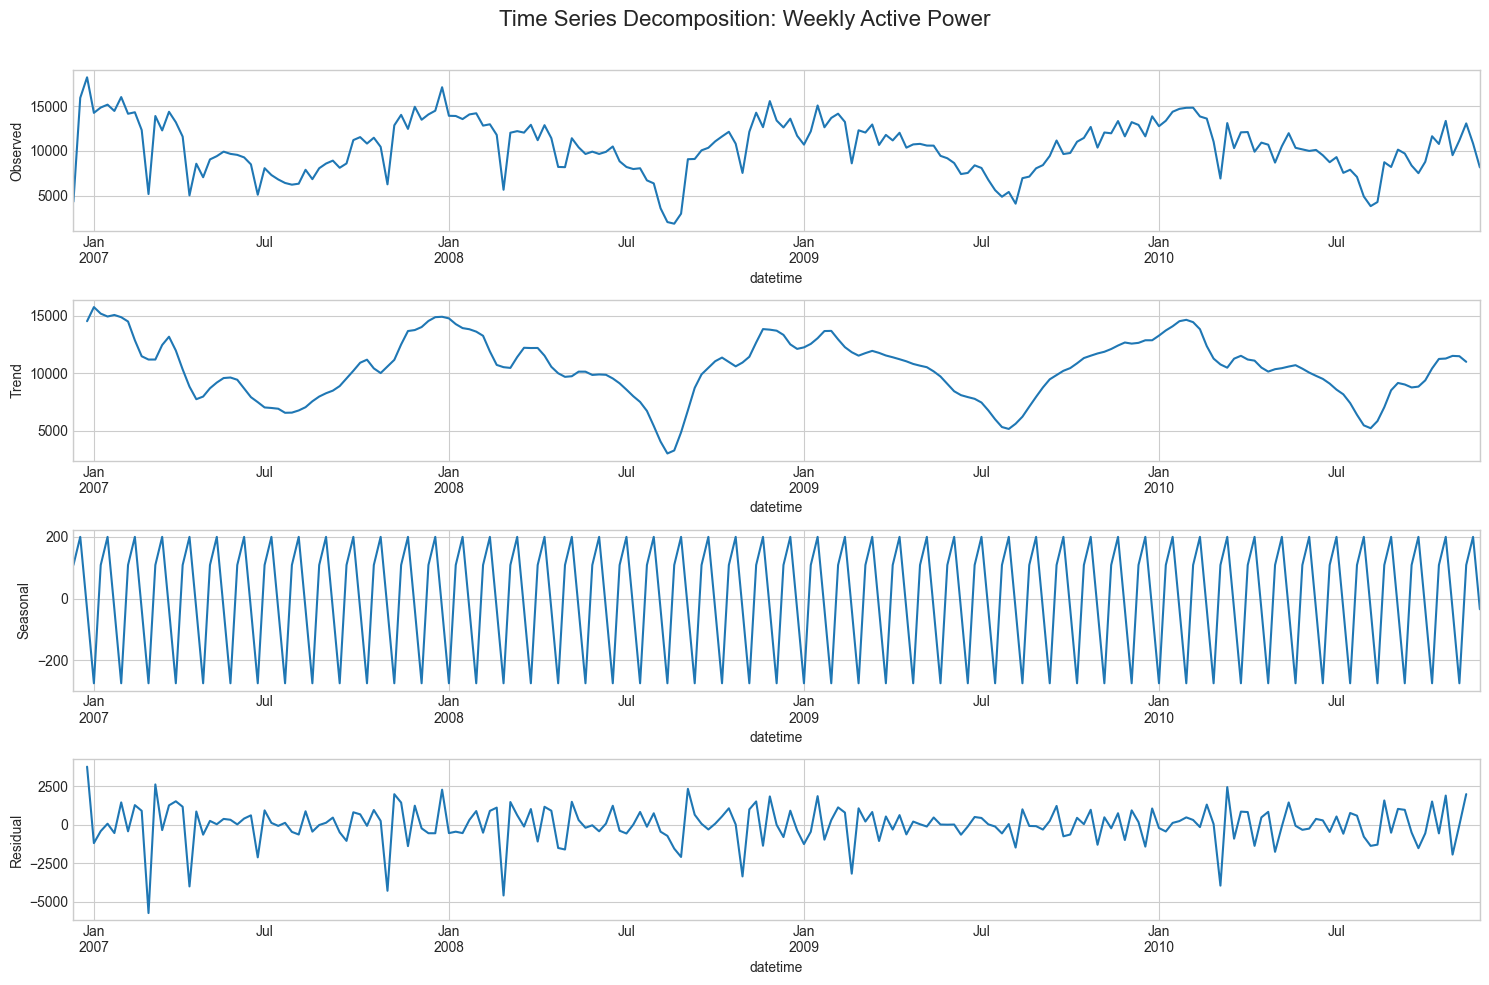

In [92]:
def decompose_series(series, period, title):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
    fig.suptitle(f'Time Series Decomposition: {title}', fontsize=16)
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    return decomposition

# Decompose at different frequencies
daily_decomp = decompose_series(daily['Global_active_power'], period=7, title='Daily Active Power')
weekly_decomp = decompose_series(weekly['Global_active_power'], period=4, title='Weekly Active Power')


##### Correlation Analysis

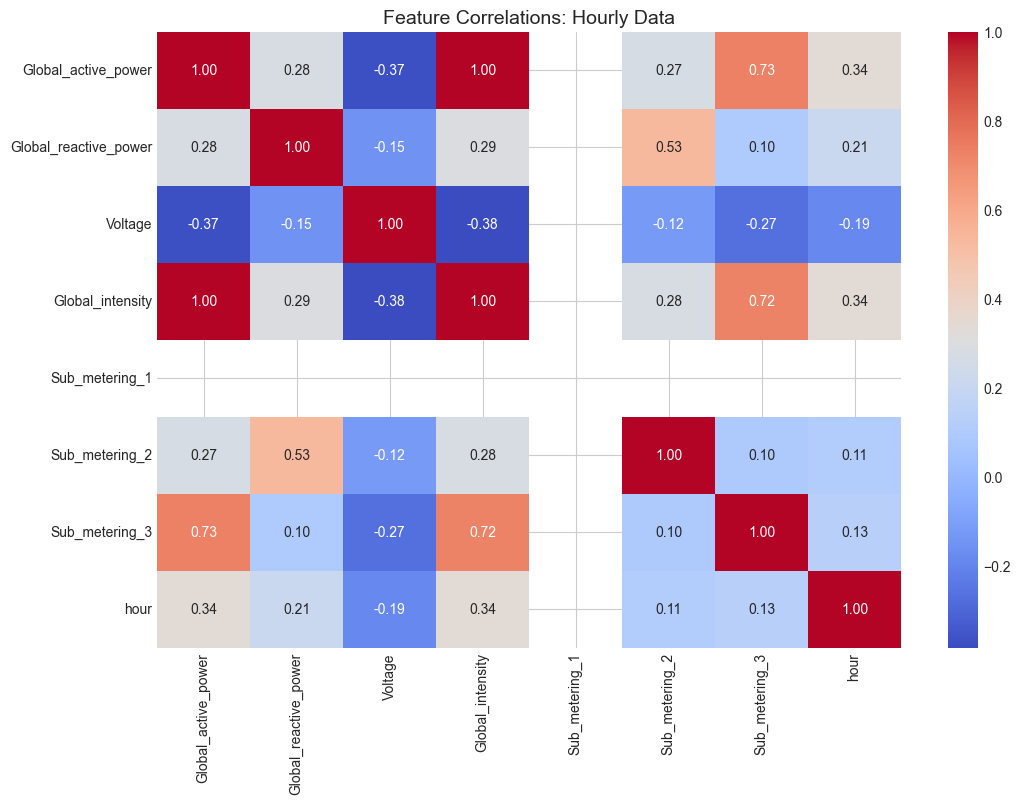

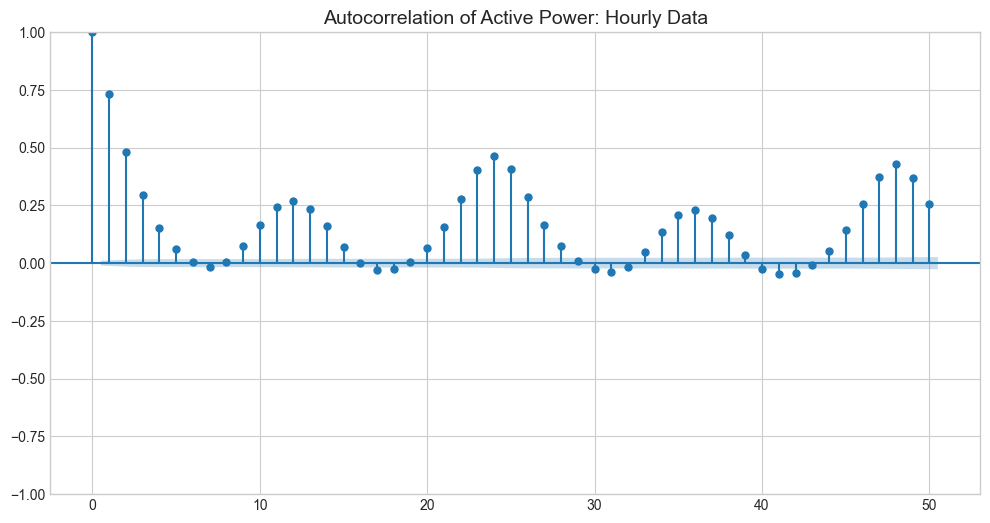

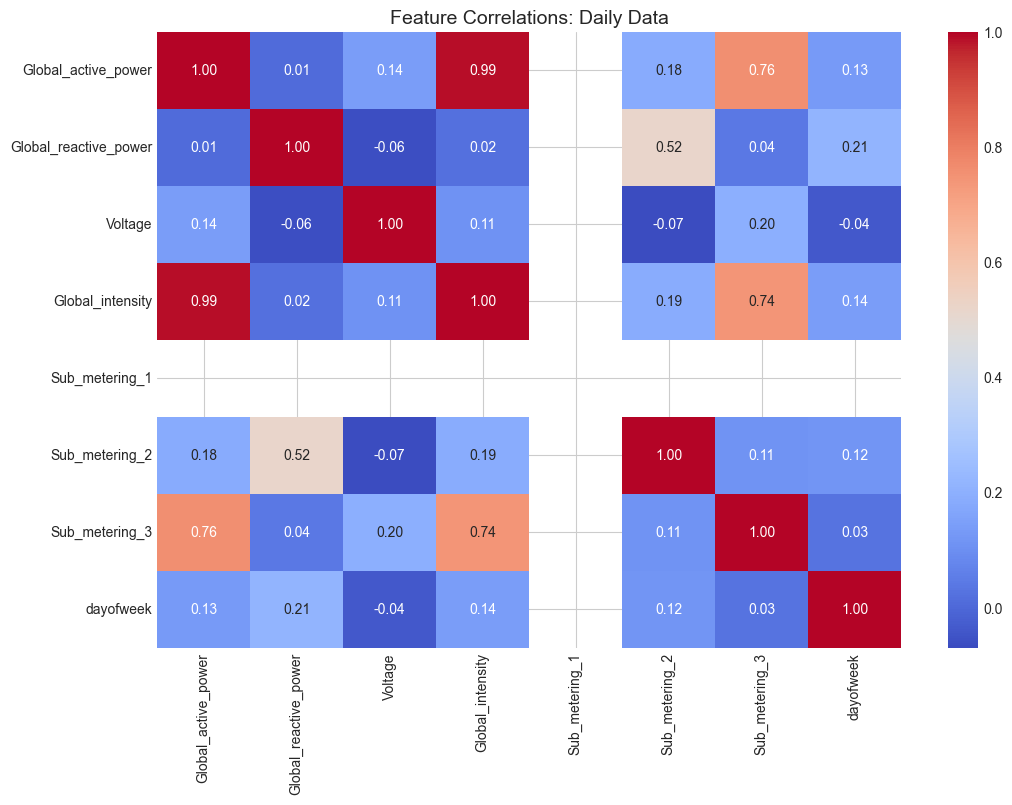

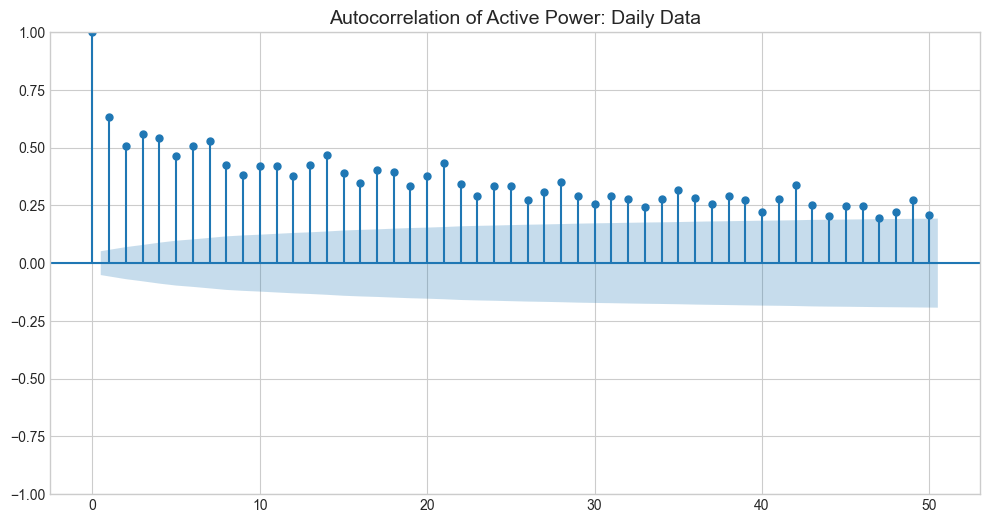

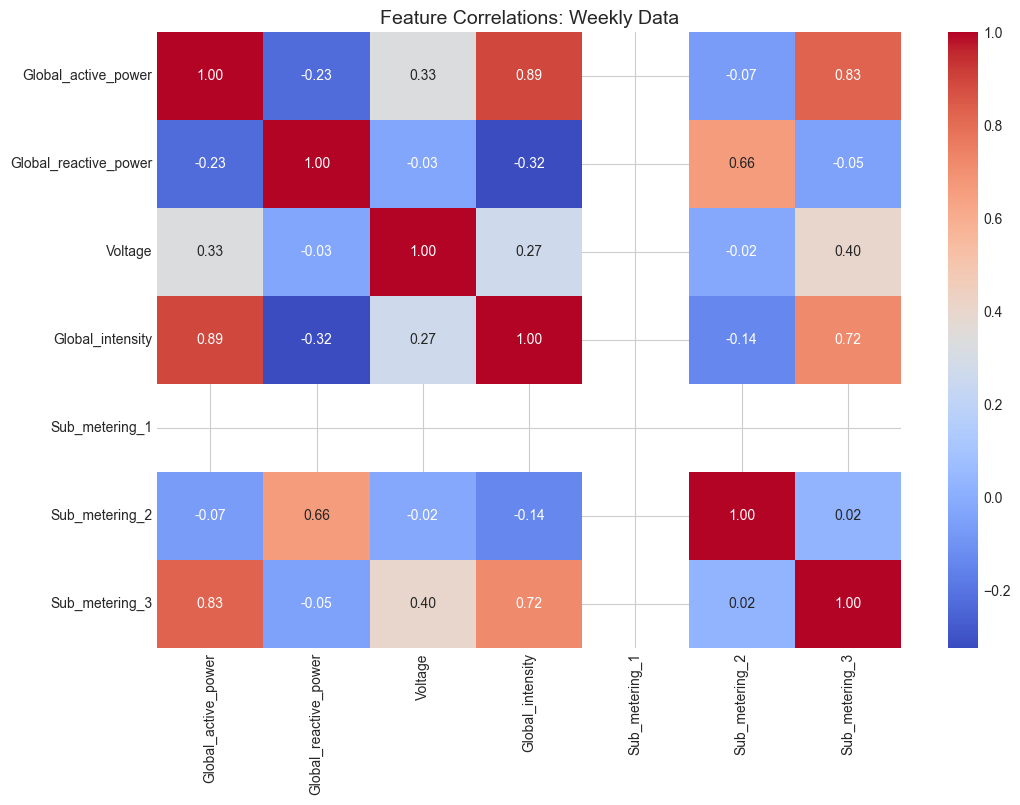

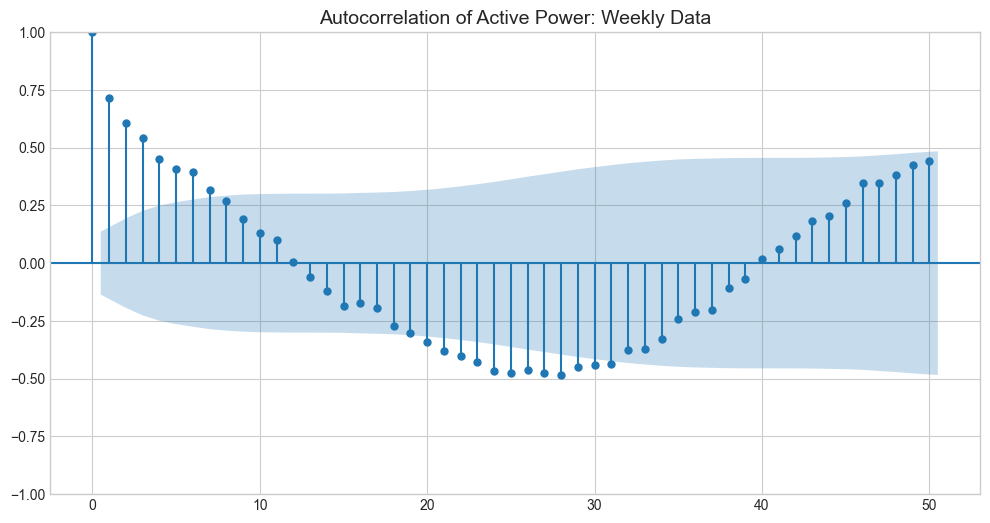

In [95]:
def plot_correlations(data, title):
    # Feature correlations
    plt.figure(figsize=(12, 8))
    corr = data.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Feature Correlations: {title}', fontsize=14)
    plt.show()
    
    # Lag correlations
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_acf(data['Global_active_power'], lags=50, ax=ax)
    plt.title(f'Autocorrelation of Active Power: {title}', fontsize=14)
    plt.show()

plot_correlations(hourly, 'Hourly Data')
plot_correlations(daily, 'Daily Data')
plot_correlations(weekly, 'Weekly Data')

##### Peak Demand Analysis


In [97]:
def analyze_peak_demand(data_dict):
    results = {}
    
    for freq, data in data_dict.items():
        # Find top 5 peak periods
        peak_periods = data.nlargest(5, 'Global_active_power')
        
        # Calculate peak contribution
        peak_contribution = peak_periods['Global_active_power'].sum() / data['Global_active_power'].sum() * 100
        
        results[freq] = {
            'peak_periods': peak_periods.index,
            'peak_values': peak_periods['Global_active_power'].values,
            'peak_contribution': peak_contribution,
            'avg_peak_demand': peak_periods['Global_active_power'].mean(),
            'max_demand': data['Global_active_power'].max()
        }
    
    # Print peak analysis report
    print("Peak Demand Analysis:")
    for freq, res in results.items():
        print(f"\n{freq.capitalize()} Level:")
        print(f"- Max Demand: {res['max_demand']:.2f} kW")
        print(f"- Avg Peak Demand (Top 5): {res['avg_peak_demand']:.2f} kW")
        print(f"- Top 5 Peaks Contribute: {res['peak_contribution']:.2f}% of total")
        print("- Peak Timestamps:")
        for ts, val in zip(res['peak_periods'], res['peak_values']):
            print(f"  {ts}: {val:.2f} kW")
    
    return results

peak_results = analyze_peak_demand(new_df)



Peak Demand Analysis:

Hourly Level:
- Max Demand: 200.88 kW
- Avg Peak Demand (Top 5): 200.88 kW
- Top 5 Peaks Contribute: 0.05% of total
- Peak Timestamps:
  2006-12-20 21:00:00: 200.88 kW
  2006-12-31 12:00:00: 200.88 kW
  2006-12-31 13:00:00: 200.88 kW
  2007-01-07 18:00:00: 200.88 kW
  2007-01-11 19:00:00: 200.88 kW

Daily Level:
- Max Demand: 3931.13 kW
- Avg Peak Demand (Top 5): 3579.61 kW
- Top 5 Peaks Contribute: 0.83% of total
- Peak Timestamps:
  2006-12-23 00:00:00: 3931.13 kW
  2006-12-26 00:00:00: 3689.83 kW
  2007-02-03 00:00:00: 3566.17 kW
  2007-02-18 00:00:00: 3360.49 kW
  2006-12-31 00:00:00: 3350.43 kW

Weekly Level:
- Max Demand: 18251.19 kW
- Avg Peak Demand (Top 5): 16593.19 kW
- Top 5 Peaks Contribute: 3.83% of total
- Peak Timestamps:
  2006-12-31 00:00:00: 18251.19 kW
  2007-12-30 00:00:00: 17140.87 kW
  2007-02-04 00:00:00: 16038.95 kW
  2006-12-24 00:00:00: 15948.03 kW
  2008-11-30 00:00:00: 15586.92 kW


##### Load Duration Curve


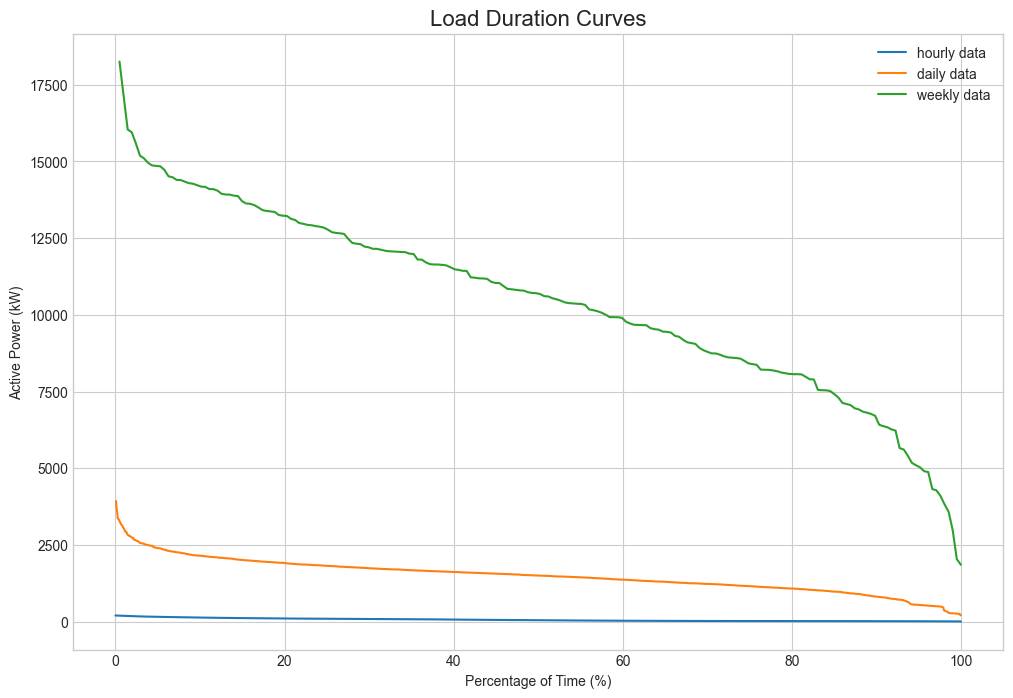

In [98]:
def plot_load_duration_curve(data_dict):
    plt.figure(figsize=(12, 8))
    
    for freq, data in data_dict.items():
        sorted_load = np.sort(data['Global_active_power'])[::-1]
        duration = np.arange(1, len(sorted_load)+1) / len(sorted_load) * 100
        plt.plot(duration, sorted_load, label=f'{freq} data')
    
    plt.title('Load Duration Curves', fontsize=16)
    plt.xlabel('Percentage of Time (%)')
    plt.ylabel('Active Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_load_duration_curve(new_df)



##### Statistical Summary


In [99]:
def print_statistical_summary(data_dict):
    for freq, data in data_dict.items():
        print(f"\n{'='*50}")
        print(f"Statistical Summary: {freq.capitalize()} Data")
        print('='*50)
        
        # Basic statistics
        print("\nGlobal Active Power:")
        print(data['Global_active_power'].describe().to_string())
        
        # Volatility analysis
        daily_volatility = data['Global_active_power'].pct_change().std() * np.sqrt(365) if freq == 'daily' else None
        print(f"\nVolatility: {data['Global_active_power'].std():.2f} kW")
        if daily_volatility:
            print(f"Annualized Volatility: {daily_volatility*100:.2f}%")
        
        # Normality test
        from scipy.stats import shapiro
        stat, p = shapiro(data['Global_active_power'].dropna())
        print(f"\nNormality Test (Shapiro-Wilk): p-value = {p:.4f}")
        print("Data appears normal" if p > 0.05 else "Data does NOT appear normal")

print_statistical_summary(new_df)


Statistical Summary: Hourly Data

Global Active Power:
count    34589.000000
mean        62.549162
std         47.639380
min          2.804000
25%         20.476000
50%         47.720000
75%         93.650000
max        200.880000

Volatility: 47.64 kW

Normality Test (Shapiro-Wilk): p-value = 0.0000
Data does NOT appear normal

Statistical Summary: Daily Data

Global Active Power:
count    1442.00000
mean     1500.35573
std       539.72976
min       210.24000
25%      1156.20400
50%      1503.87900
75%      1817.71950
max      3931.12800

Volatility: 539.73 kW
Annualized Volatility: 685.33%

Normality Test (Shapiro-Wilk): p-value = 0.0000
Data does NOT appear normal

Statistical Summary: Weekly Data

Global Active Power:
count      207.00000
mean     10451.75344
std       3014.23945
min       1854.70200
25%       8404.37300
50%      10674.45600
75%      12733.95400
max      18251.18600

Volatility: 3014.24 kW

Normality Test (Shapiro-Wilk): p-value = 0.1043
Data appears normal


c:\Users\AliRashaideh\OneDrive - Seagulls\Desktop\energy_forecasting_project\eng\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34589.
  res = hypotest_fun_out(*samples, **kwds)
